In [1]:
import pylast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

API_KEY = '42d5a344a079b31fdf1e25696a8bd517'
API_SECRET = '02bcec5c2ab24babcc5f5cba374276fb'

network = pylast.LastFMNetwork(api_key=API_KEY, api_secret=API_SECRET)

In [2]:
# Generate a list of users using their friends 
def make_friends_list(initial_user, min_length=1000, friends_list=[], initial_users_list=[]):
    
    # Add initial user to friends list
    friends_list.append(initial_user)
    # Add initial user to list of user "seeds"
    initial_users_list.append(initial_user)
    # Get user's friends
    user = network.get_user(initial_user)
    user_friends = user.get_friends(limit=None)

    # Add friends to user list 
    for i in range(len(user_friends)):
        # Make sure they're not already in the list
        if user_friends[i].get_name() not in friends_list:
            friends_list.append(user_friends[i].get_name()) 
    
    # Find another user whose friends can be added to list
    for i in range(len(friends_list)):
        # Make sure they haven't already been used as a seed
        if friends_list[i] not in initial_users_list:
            new_user = friends_list[i]
    
    # Look at new user's friend's list until list is sufficiently long
    while len(friends_list) < min_length:
        list = make_friends_list(initial_user=new_user, min_length=min_length, friends_list=friends_list, 
                                 initial_users_list=initial_users_list)
    
    # Remove duplicates
    return set(friends_list)

In [3]:
# Create a DataFrame with user, artist, and play count columns
def get_playcounts_from_users(users_list):

    artist_plays_list = []
    users_list = list(users_list)

    # Loop through users
    for user_name in users_list:
        # Get the user's top artists
        user = network.get_user(user_name)
        user_artists = user.get_top_artists()
        
        # For each user and each artist they listen to, create a list containing the username, artist, and play count
        for i in range(len(user_artists)):
            artist_name = user_artists[i]._asdict()['item'].get_name()
            num_plays = int(user_artists[i]._asdict()['weight'])
            artist_list = [user_name, artist_name, num_plays]
            # Create a list of lists containing this info
            artist_plays_list.append(artist_list)
            
    # Create DataFrame 
    df = pd.DataFrame(artist_plays_list)
    df.columns = ['user', 'artist', 'plays']
            
    return df

In [4]:
# Create a DataFrame using jonhdee23 as a seed user
user = 'jonhdee23'
users_list = make_friends_list(user)
playcounts_df = get_playcounts_from_users(users_list)

In [6]:
# Create a pivot table with users as rows, artists as columns, and play counts as values
playcounts_table = playcounts_df.pivot(index='user', columns='artist', values='plays').fillna(0)

# Create a list of total play counts for each artist and sort in descending order
playcounts_per_artist = playcounts_table.sum()
playcounts_per_artist = playcounts_per_artist.sort_values(ascending=False)

In [7]:
# Look at summary statistics, checking for outliers
playcounts_per_artist.describe()

count     14474.000000
mean       2978.233729
std       13746.000059
min           1.000000
25%         180.250000
50%         585.000000
75%        1810.750000
max      846849.000000
dtype: float64

In [8]:
# Assign 25th percentile to bottom_quarter variable
bottom_quarter = playcounts_per_artist.describe()['25%']

# Subset play counts below 25th percentile
playcounts_bottom_quarter = playcounts_per_artist[playcounts_per_artist <= bottom_quarter]

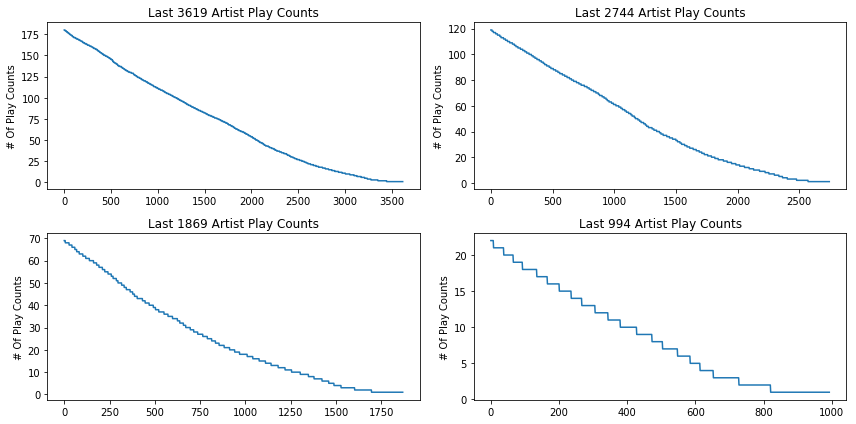

In [45]:
# Round number of values to multiple of 500
num_of_playcounts = len(playcounts_bottom_quarter)
num_of_playcounts_rounded = num_of_playcounts - (num_of_playcounts % 500)
num_of_plots = 4

# Increase width of plots
width = 12
height = 6
plt.figure(figsize=(width, height))

num_of_rows = 2
num_of_cols = 2

# Successfully zoom into plot of bottom quarter of playcounts distribution
for pos_index, xlim in enumerate(np.arange(0, num_of_playcounts_rounded, num_of_playcounts_rounded / num_of_plots)):
    plt.subplot(num_of_rows, num_of_cols, pos_index+1)
    num_of_values = num_of_playcounts - int(xlim)
    plt.title('Last {} Artist Play Counts'.format(num_of_values))
    plt.ylabel('# Of Play Counts')
    plt.plot(playcounts_bottom_quarter.values[int(xlim):])
plt.tight_layout()
plt.show()

In [50]:
# Only include artists with a sufficient number of play counts
playcounts_per_artist = playcounts_per_artist[playcounts_per_artist >= bottom_quarter]
# Check how many artists are left 
len(playcounts_per_artist)

10855

In [51]:
# Create list of artist names with playcounts above 25th percentile
artists_with_sufficient_playcounts = list(playcounts_per_artist.index)
# Only include those artists in our DataFrame
playcounts_table_original = playcounts_table
playcounts_table = playcounts_table[artists_with_sufficient_playcounts]
# Check that the right number of artists were included
len(playcounts_table.columns)

10855

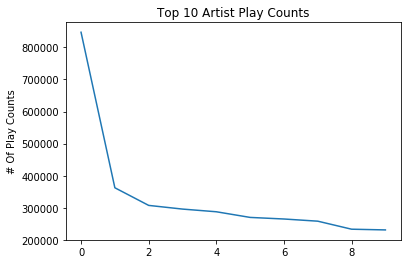

In [46]:
# Plot 10 highest play counts
plt.plot(playcounts_per_artist.values[:10])
plt.title('Top 10 Artist Play Counts')
plt.ylabel('# Of Play Counts')
plt.show()

In [12]:
# Numerically inspect 10 highest play counts
playcounts_per_artist[:10]

artist
The Cure                     846849.0
Depeche Mode                 362668.0
Radiohead                    307793.0
Placebo                      296332.0
PJ Harvey                    287979.0
Nine Inch Nails              270393.0
Nick Cave & The Bad Seeds    265453.0
David Bowie                  258675.0
The Beatles                  233696.0
Madonna                      231469.0
dtype: float64

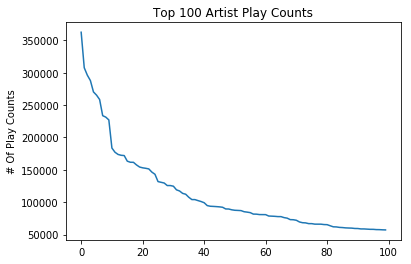

In [47]:
# Plot 100 highest play counts, excluding the highest
plt.plot(playcounts_per_artist.values[1:101])
plt.title('Top 100 Artist Play Counts')
plt.ylabel('# Of Play Counts')
plt.show()

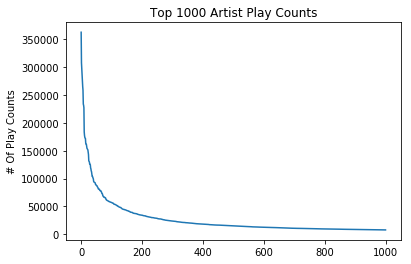

In [48]:
# Plot 1000 highest play counts, excluding the highest
plt.plot(playcounts_per_artist.values[1:1001])
plt.title('Top 1000 Artist Play Counts')
plt.ylabel('# Of Play Counts')
plt.show()

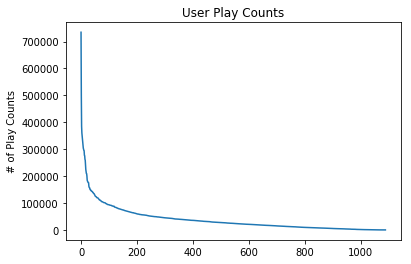

In [49]:
# Also plot playcounts per user 
playcounts_per_user = playcounts_table.sum(1).sort_values(ascending=False)
plt.plot(playcounts_per_user.values)
plt.title('User Play Counts')
plt.ylabel('# of Play Counts')
plt.show()

In [17]:
scaler = preprocessing.MinMaxScaler()

# Normalize across each artist (users as rows, artists as columns)
df_to_scale = playcounts_table
scaled_across_artists_df = pd.DataFrame(scaler.fit_transform(df_to_scale))
# Label columns using artist names
scaled_across_artists_df.columns = df_to_scale.columns
# Create user column to use when melting
scaled_across_artists_df['user'] = df_to_scale.index
# Melt dataframe to proper format for Surprise library
scaled_across_artists_df = pd.melt(scaled_across_artists_df, id_vars='user', var_name='artist')
# Remove rows with values of 0
scaled_across_artists_df = scaled_across_artists_df[scaled_across_artists_df['value'] != 0]

In [18]:
scaler = preprocessing.MinMaxScaler()

# Normalize across each user (artists as rows, users as columns)
df_to_scale = playcounts_table.transpose()
scaled_across_users_df = pd.DataFrame(scaler.fit_transform(df_to_scale))
# Label columns and index
scaled_across_users_df.columns = df_to_scale.columns
scaled_across_users_df.index = df_to_scale.index
# Transpose dataframe
scaled_across_users_df = scaled_across_users_df.transpose()

# Create user column to use when melting
scaled_across_users_df.reset_index(inplace=True)
# Melt dataframe to proper format for Surprise library
scaled_across_users_df = pd.melt(scaled_across_users_df, id_vars=['user'], var_name='artist')
# Remove rows with values of 0
scaled_across_users_df = scaled_across_users_df[scaled_across_users_df['value'] != 0]

In [19]:
from surprise import Reader, Dataset

reader = Reader(rating_scale=(0,1))
artist_data  = Dataset.load_from_df(scaled_across_artists_df, reader)
user_data = Dataset.load_from_df(scaled_across_users_df, reader)

In [34]:
from surprise.model_selection import GridSearchCV

# Get optimal parameters using Grid Search
def get_best_params(algo, param_grid, datasets=[user_data, artist_data]):
    
    params = []
    
    for dataset in datasets:
        model = GridSearchCV(algo, param_grid, cv=3)
        model.fit(dataset)
        # Get best parameters using rmse as evaluation metric
        best_params = model.best_params['rmse']
        params.append(best_params)
    
    return params

In [63]:
from surprise import SVD

# Perform GridSearch on SVD parameters
param_grid = {'n_factors': [1, 10, 25, 50, 100, 200], 'lr_all' : [0.005, 0.01, 0.025, 0.005]}
svd_user_params, svd_artist_params = get_best_params(SVD, param_grid)

In [64]:
from surprise import NMF

# Perform GridSearch on NMF parameters
param_grid = {'n_factors': [5, 10, 15, 25, 50]}
nmf_user_params, nmf_artist_params = get_best_params(NMF, param_grid)

In [30]:
from surprise import KNNBasic

# Perform GridSearch on KNN parameters
param_grid = {'k': np.arange(10,51,10)}
knn_user_params, knn_artist_params = get_best_params(KNNBasic, param_grid)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [22]:
from surprise import accuracy
from surprise.model_selection import KFold

def get_rmse_scores(algo, datasets=[user_data, artist_data]):
    
    scores = []
    mean_errors = []

    # Define a cross-validation iterator
    kf = KFold(n_splits=5)
    
    # Select which algorithm to use
    algo = algo

    # Get scores for different datasets
    for dataset in datasets:
        
        # Calculate scores for each split
        for trainset, testset in kf.split(dataset):

            # Train and test algorithm
            algo.fit(trainset)
            predictions = algo.test(testset)

            # Store RMSE scores in the 'scores' list
            rmse_score = accuracy.rmse(predictions, verbose=False)
            scores.append(rmse_score)
        
        # Calculate the mean of the scores and store in 'mean_errors' list
        mean_errors.append(np.mean(scores))
            
    return mean_errors

In [67]:
from surprise import NormalPredictor, BaselineOnly
from surprise import SlopeOne

# Collect RMSE scores for different models
rmse_data = []

normal_scores = get_rmse_scores(NormalPredictor())
rmse_data.append(normal_scores)

baseline_scores = get_rmse_scores(BaselineOnly(verbose=False))
rmse_data.append(baseline_scores)

# Use parameters selected by GridSearch for both user-scaled and artist-scaled data
svd_user_score = get_rmse_scores(SVD(**svd_user_params), [user_data])
svd_artist_score = get_rmse_scores(SVD(**svd_artist_params), [artist_data])
rmse_data.append([svd_user_score[0], svd_artist_score[0]])

nmf_user_score = get_rmse_scores(NMF(**nmf_user_params), [user_data])
nmf_artist_score = get_rmse_scores(NMF(**nmf_artist_params), [artist_data])
rmse_data.append([nmf_user_score[0], nmf_artist_score[0]])

sim_options = {'name': 'cosine', 'user_based': True}
knn_user_cosine_scores = get_rmse_scores(KNNBasic(**knn_user_params, sim_options=sim_options, verbose=False))
knn_artist_cosine_scores = get_rmse_scores(KNNBasic(**knn_artist_params, sim_options=sim_options, verbose=False))
rmse_data.append([knn_user_cosine_scores[0], knn_artist_cosine_scores[0]])

sim_options = {'name': 'pearson', 'user_based': True}
knn_user_pearson_scores = get_rmse_scores(KNNBasic(**knn_user_params, sim_options=sim_options, verbose=False))
knn_artist_pearson_scores = get_rmse_scores(KNNBasic(**knn_artist_params, sim_options=sim_options, verbose=False))
rmse_data.append([knn_user_pearson_scores[0], knn_artist_pearson_scores[0]])

/home/hussain/anaconda3/lib/python3.6/site-packages/surprise/prediction_algorithms/algo_base.py:293: RuntimeWarning: invalid value encountered in sqrt
  sim = construction_func[name](*args)


In [24]:
# Create table of RMSCE scores
rmse_table = pd.DataFrame(rmse_data)
index_names = ['NormalPredictor', 'Baseline', 'SVD', 'NMF', 'User-based cosine-KNN', 'User-based Pearson-KNN']
col_names = ['User scaled', 'Artist scaled']
rmse_table.index = index_names
rmse_table.columns = col_names

In [25]:
rmse_table

,User scaled,Artist scaled
NormalPredictor,0.291925,0.396527
Baseline,0.186361,0.231003
SVD,0.184444,0.245794
NMF,0.207086,0.324503
User-based cosine-KNN,0.228834,0.231486
User-based Pearson-KNN,0.234469,0.235909


In [26]:
# Create table of predicted recommendation scores for users and artists
def get_recs_table(dataset, algo):

    trainset = dataset.build_full_trainset()

    algo = algo
    algo.fit(trainset)

    predictions = {}
    
    # Look at every artist
    for artist in playcounts_table.columns:
    
        predictions_for_user = []
    
        # Only look at every other user for the sake of runtime
        for user in playcounts_table.index[::2]:
            predicted_rec_score = algo.predict(user, artist)[3]
            predictions_for_user.append(predicted_rec_score)
            predictions[artist] = predictions_for_user
            
    recs_table = pd.DataFrame(predictions)
    recs_table.index= playcounts_table.index[::2]
    
    return recs_table

In [27]:
# Get predicted recommendation scores for SVD model on user-scaled data
predicted_scores = get_recs_table(user_data, SVD(**svd_user_params, verbose=False))
predicted_scores.head()

,!!!,!Action Pact!,!distain,"""Weird Al"" Yankovic",$LUDGEHAMMER,$OUDIERE,$UICIDEBOY$ x RVMIRXZ,$uicideboy$,$uicideboy$ x Germ,'Til Tuesday,...,손담비,시와무지개,에이오에이,원더걸스 (Wonder Girls),잠비나이,티아라,폐허,푸른새벽,회사AUTO,２８１４
user,,,,,,,,,,,,,,,,,,,,,
-Miles-,0.067090,0.085594,0.100489,0.064859,0.088439,0.073703,0.084294,0.176710,0.076497,0.079984,...,0.076625,0.074114,0.096472,0.067649,0.081386,0.083866,0.073154,0.071840,0.080434,0.079712
ACEpapella,0.194037,0.205205,0.226973,0.186924,0.209117,0.191780,0.198822,0.299172,0.200231,0.204399,...,0.202802,0.199644,0.214408,0.205153,0.194328,0.208674,0.197755,0.200274,0.197509,0.195718
ALF_Fighter,0.155648,0.162412,0.188305,0.145605,0.166966,0.148067,0.152978,0.258091,0.159914,0.164491,...,0.163950,0.160404,0.170610,0.173101,0.147533,0.169000,0.157957,0.162778,0.153195,0.150762
AdreenaLiNa,0.279823,0.293022,0.312886,0.274062,0.296639,0.280022,0.288046,0.386200,0.286907,0.290886,...,0.288801,0.285822,0.302689,0.288015,0.283992,0.295052,0.284190,0.285648,0.286029,0.284533
Agnetha1950,0.100397,0.113782,0.133473,0.094760,0.117372,0.100821,0.108936,0.206888,0.107562,0.111525,...,0.109394,0.106432,0.123492,0.108321,0.104922,0.115680,0.104824,0.106185,0.106854,0.105385


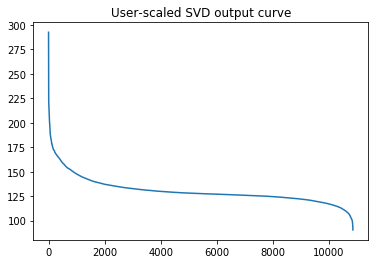

In [28]:
# Inspect curve of artist recommendation scores

# Get a score summed across users for each artist
predicted_scores_per_artist = predicted_scores.sum()
# Sort scores
predicted_scores_per_artist = predicted_scores_per_artist.sort_values(ascending=False)

plt.plot(predicted_scores_per_artist.values)
plt.title('User-scaled SVD output curve')
plt.show()

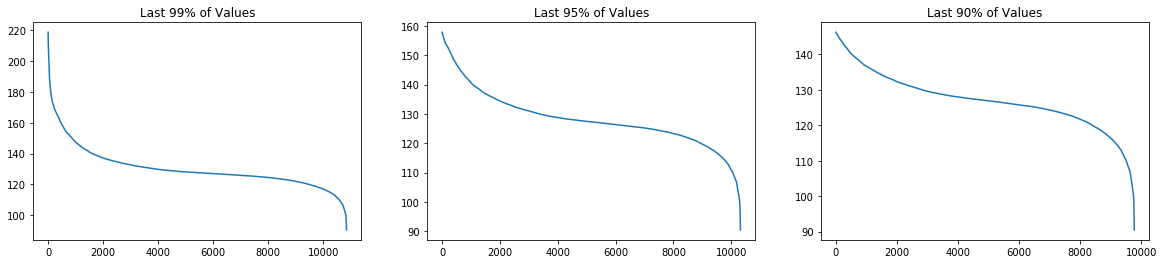

In [63]:
# Zoom into user-scaled SVD output curve
one_percent = int(len(predicted_scores_per_artist) * .001)
five_percent = int(len(predicted_scores_per_artist) * .05)
ten_percent = int(len(predicted_scores_per_artist) * .1)

width = 20
height = 4

plt.figure(figsize=(width, height))

plt.subplot(1, 3, 1)
plt.title('Last 99% of Values')
plt.plot(predicted_scores_per_artist.values[one_percent:])
plt.subplot(1, 3, 2)
plt.title('Last 95% of Values')
plt.plot(predicted_scores_per_artist.values[five_percent:])
plt.subplot(1, 3, 3)
plt.title('Last 90% of Values')
plt.plot(predicted_scores_per_artist.values[ten_percent:])
plt.show()

In [30]:
def get_output_curve(data, algo):
    
    predicted_scores = get_recs_table(data, algo)
    predicted_scores_per_artist = predicted_scores.sum()
    predicted_scores_per_artist = predicted_scores_per_artist.sort_values(ascending=False)
    
    return predicted_scores_per_artist.values

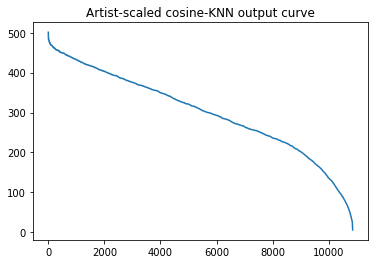

In [52]:
# Inspect curve of artist recommendation scores for artist-scaled data
sim_options = {'name': 'cosine', 'user_based': True}
knn_artist_algo = KNNBasic(**knn_artist_params, sim_options=sim_options, verbose=False)
artist_scaled_scores = get_output_curve(artist_data, knn_artist_algo)
plt.plot(artist_scaled_scores)
plt.title('Artist-scaled cosine-KNN output curve')
plt.show()

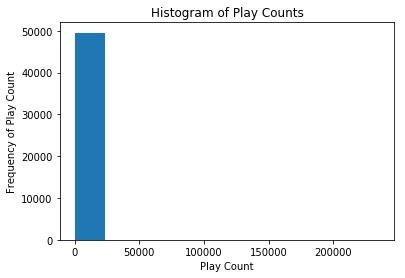

In [72]:
# Look at distribution of non-normalized data (play counts)
plt.hist(non_normalized_df['value'])
plt.title('Histogram of Play Counts')
plt.xlabel('Play Count')
plt.ylabel('Frequency of Play Count')
plt.show()

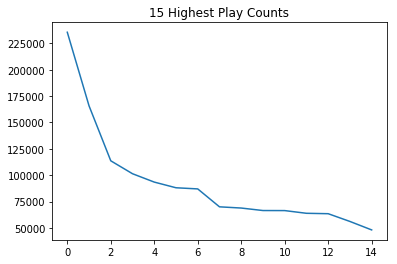

In [74]:
# Check for outliers 
plt.plot(non_normalized_df['value'].sort_values(ascending=False).values[:15])
plt.title('15 Highest Play Counts')
plt.show()

In [85]:
# Store outlier values
first_outlier, second_outlier = non_normalized_df['value'].sort_values(ascending=False).values[:2]

In [87]:
# Transform non-normalized data for Surprise to use
non_normalized_df = pd.DataFrame(playcounts_table)
non_normalized_df['user'] = non_normalized_df.index
non_normalized_df = pd.melt(non_normalized_df, id_vars=['user'], var_name='artist')
non_normalized_df = non_normalized_df[non_normalized_df['value'] != 0]
# Remove outliers
non_normalized_df = non_normalized_df[non_normalized_df['value'] != first_outlier]
non_normalized_df = non_normalized_df[non_normalized_df['value'] != second_outlier]

reader = Reader(rating_scale=(0, max(non_normalized_df['value'].values)))
non_normalized_data  = Dataset.load_from_df(non_normalized_df, reader)

In [91]:
# Perform GridSearch on SVD parameters
param_grid = {'n_factors': [1, 10, 25, 50, 100, 200], 'lr_all' : [0.005, 0.01, 0.025, 0.005]}
svd_params = get_best_params(SVD, param_grid, [non_normalized_data])

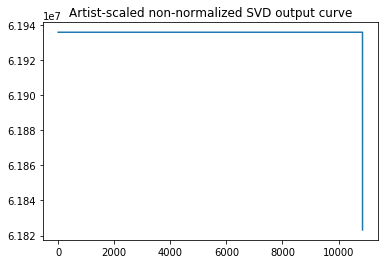

In [92]:
# Get output curve for SVD model on non-normalized data (play counts) 
output_scores = get_output_curve(non_normalized_data, SVD(**svd_params[0], verbose=False))
plt.plot(output_scores)
plt.title('Artist-scaled non-normalized SVD output curve')
plt.show()

In [94]:
# Check how many unique scores we have
len(np.unique(output_scores))

2

In [168]:
def get_top_recommendations(user, n=10, data=artist_data, algo=KNNBasic(**knn_artist_params,
                                                                        sim_options=sim_options,
                                                                        verbose=False)):
    
    # Create training set on full dataset
    trainset = data.build_full_trainset()

    predicted_scores = {}
    artists = []

    # Fit model
    algo.fit(trainset)
    # Get predicted scores for each artist
    for artist in playcounts_table.columns:
        predicted_scores[artist] = algo.predict(user, artist)[3]
    
    # Only include artists with scores less than 1
    updated_scores = {artist: score for artist, score in predicted_scores.items() if score < 1}
    # Sort scores from highest to lowest
    sorted_scores = sorted(updated_scores.items(), key=lambda kv: kv[1], reverse=True)
    
    # Get top n artists 
    for i in np.arange(n):
        artists.append(sorted_scores[i][0])
    
    return artists

In [169]:
get_top_recommendations('-Miles-')

['I LIKE TRAINS',
 'Root',
 'Elektryczne Gitary',
 'Them Crooked Vultures',
 'Strachy Na Lachy',
 'The Easybeats',
 'Patsy Cline',
 'Metallic Falcons',
 'Alex Winston',
 'Facção Central']

In [174]:
get_top_recommendations('A6_666')

['Blind Willie McTell',
 'Human Tetris',
 'Rocky Votolato',
 'Strachy Na Lachy',
 'Nicola Conte',
 'The Easybeats',
 'The Associates',
 'Patsy Cline',
 'Portion Control',
 'Facção Central']

In [175]:
get_top_recommendations('ACEpapella')

['Antitainment',
 'I LIKE TRAINS',
 'Blood Axis & Les Joyaux de la Princesse',
 'X-Fusion',
 'Human Tetris',
 'Alex Winston',
 'Facção Central',
 'Herbert',
 'Bomba Estéreo',
 'Strachy Na Lachy']